# Imports - Configs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/dicarlolab/CORnet

  Cloning https://github.com/dicarlolab/CORnet to /tmp/pip-req-build-oicvdot0
  Running command git clone --filter=blob:none --quiet https://github.com/dicarlolab/CORnet /tmp/pip-req-build-oicvdot0
  Resolved https://github.com/dicarlolab/CORnet to commit d0cc17d4b34ad44dedb01683b70eafd15515adad
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install sty

In [ ]:
!git clone https://github.com/sonerkuyar/gestalt-DNNs.git

fatal: destination path 'gestalt-DNNs' already exists and is not an empty directory.


In [ ]:
import os
os.chdir('/content/gestalt-DNNs/')

In [ ]:
#!rm -r /content/gestalt-DNNs/

# Experiments

### Experiment 1

In [ ]:
%matplotlib inline

import os, pickle, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.lines import Line2D


from src.utils.Config import Config
from src.utils.net_utils import get_layer_from_depth_str, from_depth_to_string
from src.utils.misc import config_to_path_hierarchical, brain_score_nn, additional_nets
from src.utils.create_stimuli.drawing_utils import DrawShape

#### Net vs Human

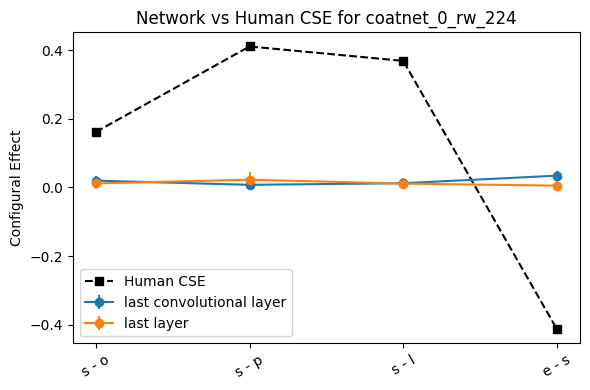

In [ ]:

# stimulus-pairs and human CSE from the script
all_pairs = [
    ['single',     'orientation'],
    ['single',     'proximity'],
    ['single',     'linearity'],
    ['empty',      'single']
]


RT = {
  'single':      np.mean([1407,1455,1400,1389])    / 1000,
  'orientation': np.mean([1430,1139,1138,1297])    / 1000,
  'proximity':   np.mean([925,994,1087,1002])      / 1000,
  'linearity':   np.mean([1016,1021,1064,1075])    / 1000,
  'empty':       np.mean([1])                      # placeholder
}
human_CSE = {
    f'{p[0][0]} - {p[1][0]}': RT[p[0]] - RT[p[1]]
    for p in all_pairs
}
all_comb = list(human_CSE.keys())

def collect(network_name, type_ds, background, depth_layer):
    pt = 'kitti' if network_name=='prednet' else 'ImageNet'
    config = Config(
        project_name='Pomerantz',
        verbose=False,
        distance_type='cossim',
        network_name=network_name,
        pretraining=pt,
        weblogger=0,
        is_pycharm=False,
        type_ds=type_ds,
        background=background
    )
    folder = f'/content/drive/MyDrive/cmpe489/results/{config_to_path_hierarchical(config)}'
    cs = pickle.load(open(folder+'cossim.df','rb'))
    layers = list(cs[type_ds].keys())
    ll = get_layer_from_depth_str(layers, depth_layer)
    return np.array(cs[type_ds][ll])

def compute_net_CSE(network, depth_layer):
    # returns (means, stds) arrays over all_pairs
    diffs = []
    for base, comp in all_pairs:
        a = collect(network, base, 'random', depth_layer)
        b = collect(network, comp, 'random', depth_layer)
        diff = -(b - a)
        diffs.append(diff)
    diffs = np.stack(diffs)    # shape (4 pairs, Nreps)
    return diffs.mean(axis=1), diffs.std(axis=1)


network = additional_nets[6]
depths  = ['last_conv_l', 'last_l']
labels  = all_comb

fig, ax = plt.subplots(figsize=(6,4))
for d in depths:
    mu, sd = compute_net_CSE(network, d)
    x = np.arange(len(labels))
    ax.errorbar(x, mu, yerr=sd, fmt='o-', label=from_depth_to_string(d))

# plot human CSE on the same x‐axis
h = [human_CSE[l] for l in labels]
ax.plot(x, h, 's--', label='Human CSE', color='black')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30)
ax.set_ylabel('Configural Effect')
ax.set_title(f'Network vs Human CSE for {network}')
ax.legend()
plt.tight_layout()
plt.show()

#### All Layers LinePlot

In [ ]:
def plot_hierarchical_CSE(network_names, bg, distance_type, normalize):
    sns.set(style="white")
    plt.close("all")
    color_cycle = np.array(plt.rcParams["axes.prop_cycle"].by_key()["color"])

    # The helper that loads & computes CE per layer:
    def collect(net_name):
        pt = "kitti" if net_name=="prednet" else "ImageNet"
        img_size = np.array((224,224),int)
        cfg = Config(
            project_name="Pomerantz",
            verbose=False,
            distance_type=distance_type,
            network_name=net_name,
            pretraining=pt,
            weblogger=0,
            is_pycharm=False,
            background=bg,
            draw_obj=DrawShape(
                background=bg if bg not in ("black","random") else "black",
                img_size=img_size, width=14
            )
        )
        folder = f"/content/drive/MyDrive/cmpe489/results/{config_to_path_hierarchical(cfg)}"
        cs     = pickle.load(open(folder + f"{distance_type}.df","rb"))

        layers = list(cs["empty"].keys())
        # normalization factor from the 'empty' vs 'empty-single' baseline:

        norm_factor = np.array([
            np.mean(np.array(cs["empty"][l]) - np.array(cs["empty-single"][l]))
            for l in layers
        ])

        # build raw CE arrays per condition/pair:
        if distance_type=="cossim":
            CE = {
              k: [ np.array(cs["single"][l]) - np.array(cs[k][l])
                   for l in layers ]
              for k in ["orientation","proximity","linearity"]
            }
            CE["empty-single"] = [
              np.array(cs["empty"][l]) - np.array(cs["empty-single"][l])
              for l in layers
            ]
        else:  # euclidean
            CE = {
              k: [
                (np.array(cs[k][l]) - np.array(cs["single"][l]))
                / (np.array(cs[k][l]) + np.array(cs["single"][l]))
                for l in layers
              ]
              for k in ["orientation","proximity","linearity"]
            }
            CE["empty-single"] = [
              (np.array(cs["empty-single"][l]) - np.array(cs["empty"][l]))
              / (np.array(cs["empty-single"][l]) + np.array(cs["empty"][l]))
              for l in layers
            ]

        for k,v in CE.items():
          lengths = [len(arr) for arr in v]
          print(f"{net_name} | {k}  lengths per layer: {lengths[:5]}... max={max(lengths)}, min={min(lengths)}")

        # mean/std (and optional normalization)
        if normalize:
            CE_m   = {k: np.array([np.mean(arr)/norm_factor[i]
                                  for i,arr in enumerate(v)])
                      for k,v in CE.items()}
            CE_std = {k: np.zeros(len(v))
                      for k,v in CE.items()}
        else:
            CE_m   = {k: np.array([np.nanmean(arr) for arr in v])
                      for k,v in CE.items()}
            CE_std = {k: np.array([np.nanstd(arr)  for arr in v])
                      for k,v in CE.items()}

        # drop any layers where CE was NaN
        valid_idx = np.isfinite(CE_m["orientation"])
        layers    = [layers[i] for i,ok in enumerate(valid_idx) if ok]
        for k in CE_m:
            CE_m[k]   = CE_m[k][valid_idx]
            CE_std[k] = CE_std[k][valid_idx]

        return CE_m, CE_std, layers

    # set up the grid of subplots
    mosaic = """
    AAAABBBBBCCC
    DDDEEEFFGGHH
    IIIJJJKKKLLL
    MMMNNNOOOPPP
    """
    fig_dict = plt.figure(constrained_layout=True).subplot_mosaic(mosaic)
    axes = list(fig_dict.values())

    # shared y-limits (tweak these if needed)
    for ax in axes:
        ax.set_ylim(-0.3, 0.8)
        ax.set_yticks([])
        ax.axhline(0, color="k", linestyle="--", linewidth=1)

    conds = ["empty-single","proximity","linearity","orientation"]

    # plot each network in its own axis
    for ax, net in zip(axes, network_names):
        CE_m, CE_s, layers = collect(net)
        x = np.arange(len(layers))
        for i, cond in enumerate(conds):
            y = CE_m[cond]
            err = CE_s[cond]
            color = color_cycle[i]
            ax.plot(x, y, color=color, linewidth=1)
            ax.fill_between(x, y+err, y-err, alpha=0.1, color=color)
            ax.plot(x[-1], y[-1], "o", color=color)

            # mark first Linear layer:
            lin_idxs = [j for j,l in enumerate(layers) if "Linear" in l]
            if lin_idxs:
                ax.axvline(lin_idxs[0], color="r", linestyle="--")

        # annotate the network name
        ax.annotate(net, xy=(0.05,0.9), xycoords="axes fraction",
                    fontsize=12, fontweight="bold")

    # global labels & legend
    fig = plt.gcf().add_subplot(111, frameon=False)
    plt.tick_params(labelcolor="none", which="both", top=False,
                    bottom=False, left=False, right=False)
    plt.xlabel("Layer depth (in order)", fontsize=14)
    plt.ylabel("Configural Effect",   fontsize=14)

    # custom legend
    lines = [
      Line2D([0],[0], color=color_cycle[i], lw=2)
      for i in range(len(conds))
    ] + [ Line2D([0],[0], marker="o", color="k", lw=0) ]
    labels = conds + ["Output layer"]
    plt.legend(lines, labels, ncol=len(labels),
               bbox_to_anchor=(0,0), loc="upper left")

    plt.show()

##### Cossim

In [ ]:
additional_nets

['efficientnet_b0',
 'convnext_base',
 'regnet_y_16gf',
 'mobilenet_v3_large',
 'swin_tiny_patch4_window7_224',
 'deit_small_patch16_224',
 'coatnet_0_rw_224',
 'pit_s_224']

In [ ]:
distance_type  = 'euclidean'   # or 'cossim'
bg             = 'random'

normalize      = False

network_names  = additional_nets# ['resnet152']#list(brain_score_nn.keys())

efficientnet_b0 | orientation  lengths per layer: [500, 500, 500, 500, 500]... max=500, min=500
efficientnet_b0 | proximity  lengths per layer: [500, 500, 500, 500, 500]... max=500, min=500
efficientnet_b0 | linearity  lengths per layer: [500, 500, 500, 500, 500]... max=500, min=500
efficientnet_b0 | empty-single  lengths per layer: [500, 500, 500, 500, 500]... max=500, min=500
convnext_base | orientation  lengths per layer: [500, 500, 500, 500, 500]... max=500, min=500
convnext_base | proximity  lengths per layer: [500, 500, 500, 500, 500]... max=500, min=500
convnext_base | linearity  lengths per layer: [500, 500, 500, 500, 500]... max=500, min=500
convnext_base | empty-single  lengths per layer: [500, 500, 500, 500, 500]... max=500, min=500
regnet_y_16gf | orientation  lengths per layer: [500, 500, 500, 500, 500]... max=500, min=500
regnet_y_16gf | proximity  lengths per layer: [500, 500, 500, 500, 500]... max=500, min=500
regnet_y_16gf | linearity  lengths per layer: [500, 500, 500

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


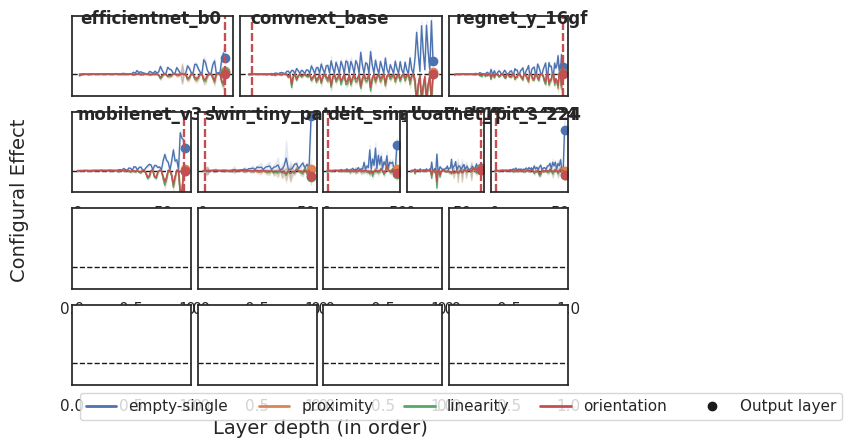

In [ ]:
plot_hierarchical_CSE(
  network_names,
  bg="random",
  distance_type="cossim",
  normalize=False
)

In [ ]:
import pandas as pd

df = pd.read_pickle("/content/drive/MyDrive/cmpe489/results/cossim/hierarchical/swin_tiny_patch4_window7_224/random_ImageNet/cossim.df")

In [ ]:
df.keys()

dict_keys(['empty', 'empty-single', 'single', 'proximity', 'orientation', 'linearity'])

#### Box-Plot

In [ ]:
%matplotlib inline
import pickle, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.lines import Line2D

from src.utils.Config import Config
from src.utils.misc import (
    main_text_nets, all_nets, appendix_nets,
    self_superv_net, transformers,
    human_CSE_exp1, config_to_path_hierarchical, brain_score_nn
)
from src.utils.net_utils import get_layer_from_depth_str
from src.utils.create_stimuli.drawing_utils import DrawShape

sns.set(style="white")
plt.rcParams['svg.fonttype'] = 'none'

In [ ]:
color_cycle = (
    plt.rcParams['axes.prop_cycle'].by_key()['color']
    + ['olive','crimson','violet','magenta','indigo','turquoise']
)

def collect(network_name, type_ds, dist_type):
    pt = 'kitti' if network_name=='prednet' else 'ImageNet'
    cfg = Config(
        project_name='Pomerantz',
        verbose=False,
        distance_type=dist_type,
        network_name=network_name,
        pretraining=pt,
        weblogger=0,
        is_pycharm=False,
        background=bk,
        draw_obj=DrawShape(
            background='black' if bk in ('black','random') else bk,
            img_size=np.array((224,224)), width=14
        )
    )
    folder = f'/content/drive/MyDrive/cmpe489/results/{config_to_path_hierarchical(cfg)}'
    cs     = pickle.load(open(folder + f'{dist_type}.df','rb'))
    layers = list(cs['empty'].keys())
    ll     = get_layer_from_depth_str(layers, depth_layer)

    # pick CE vector
    if type_ds == 'control':
        if dist_type=='cossim':
            CE = cs['empty'][ll] - np.array(cs['empty-single'][ll])
        else:
            CE = (np.array(cs['empty-single'][ll]) - cs['empty'][ll]) / \
                 (np.array(cs['empty-single'][ll]) + cs['empty'][ll])
    else:
        if dist_type=='cossim':
            CE = cs['single'][ll] - np.array(cs[type_ds][ll])
        else:
            CE = (np.array(cs[type_ds][ll]) - cs['single'][ll]) / \
                 (np.array(cs[type_ds][ll]) + cs['single'][ll])

    if normalize:
        norm = np.mean(cs['empty'][ll] - np.array(cs['empty-single'][ll]))
        CE   = CE / norm

    from scipy.stats import ttest_1samp
    pval = ttest_1samp(CE, 0).pvalue
    return np.mean(CE), np.std(CE), pval, CE

def plot_net_set(means, stds, xpos, pvals, dists, ax):
    span, space = 0.35, 0.03
    width = (span)/(len(means)-1)
    for i, dist in enumerate(dists):
        pos = xpos - span/2 + width*i
        bp = ax.boxplot(
            dist, positions=[pos], widths=width-space,
            patch_artist=True, showfliers=False,
            boxprops={'facecolor':color_cycle[i],'alpha':1,'lw':0.5},
            medianprops={'color':'k','linewidth':0.5}
        )
        # hatch if median<0
        if bp['medians'][0].get_ydata()[0] < 0:
            bp['boxes'][0].set(hatch='////', facecolor='w',
                              edgecolor=color_cycle[i])

<ipython-input-188-86d7ae768f5c>:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


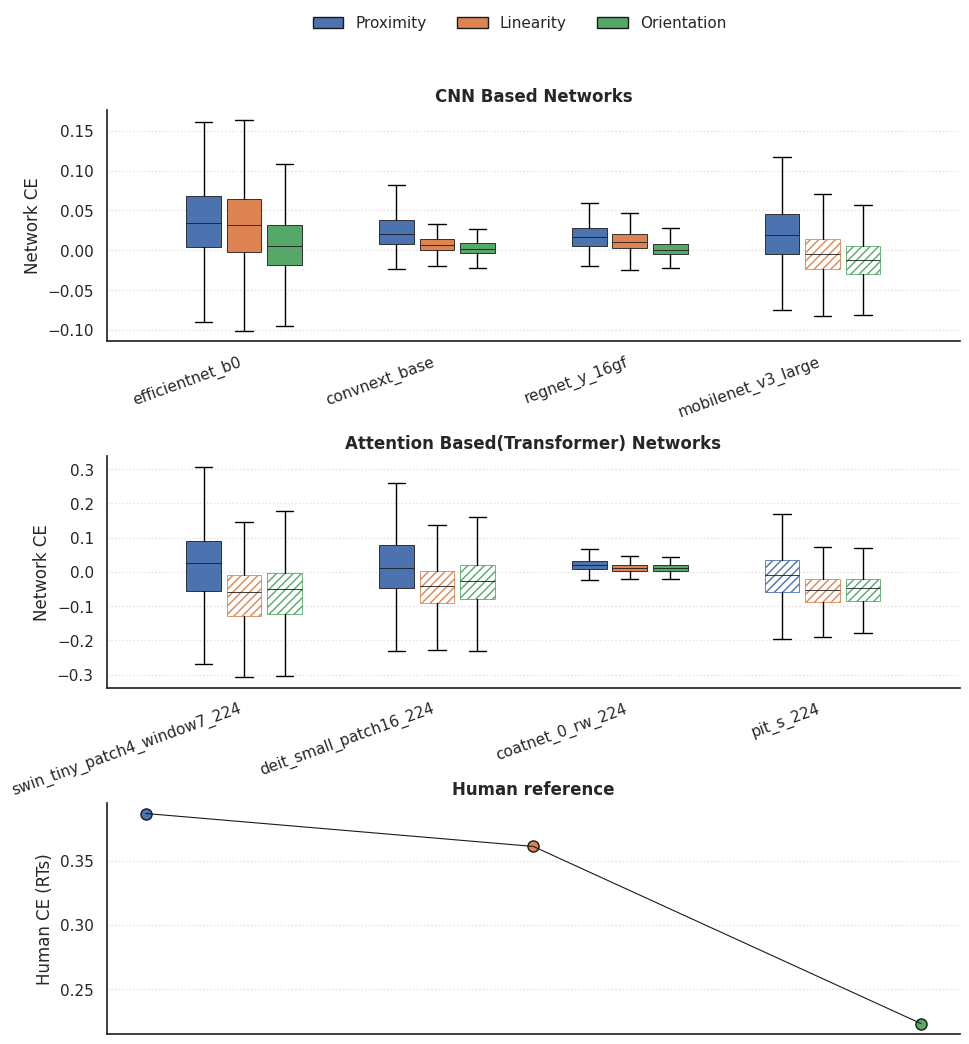

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'axes.spines.top': False,
                     'axes.spines.right': False})

# ── CONFIG ───────────────────────────────────────────────────────────────
transf        = 't'
bk            = 'random'
network_names = additional_nets         # 16 nets assumed
depth_layer   = 'last_l'
normalize     = False
distance_type = 'cossim'
split         = 4                      # 1st row = 0…7, 2nd row = 8…15

# 3 stimulus types → 3 colours
type_names    = ['proximity', 'linearity', 'orientation']
type_cols     = (plt.rcParams['axes.prop_cycle']
                 .by_key()['color'][:3])  # first 3 default colours
# ─────────────────────────────────────────────────────────────────────────

def collect(network_name, type_ds, dist_type):
    pt = 'kitti' if network_name=='prednet' else 'ImageNet'
    cfg = Config(
        project_name='Pomerantz',
        verbose=False,
        distance_type=dist_type,
        network_name=network_name,
        pretraining=pt,
        weblogger=0,
        is_pycharm=False,
        background=bk,
        draw_obj=DrawShape(
            background='black' if bk in ('black','random') else bk,
            img_size=np.array((224,224)), width=14
        )
    )
    folder = f'/content/drive/MyDrive/cmpe489/results/{config_to_path_hierarchical(cfg)}'
    cs     = pickle.load(open(folder + f'{dist_type}.df','rb'))
    layers = list(cs['empty'].keys())
    ll     = get_layer_from_depth_str(layers, depth_layer)

    # pick CE vector
    if type_ds == 'control':
        if dist_type=='cossim':
            CE = cs['empty'][ll] - np.array(cs['empty-single'][ll])
        else:
            CE = (np.array(cs['empty-single'][ll]) - cs['empty'][ll]) / \
                 (np.array(cs['empty-single'][ll]) + cs['empty'][ll])
    else:
        if dist_type=='cossim':
            CE = cs['single'][ll] - np.array(cs[type_ds][ll])
        else:
            CE = (np.array(cs[type_ds][ll]) - cs['single'][ll]) / \
                 (np.array(cs[type_ds][ll]) + cs['single'][ll])

    if normalize:
        norm = np.mean(cs['empty'][ll] - np.array(cs['empty-single'][ll]))
        CE   = CE / norm

    from scipy.stats import ttest_1samp
    pval = ttest_1samp(CE, 0).pvalue
    return np.mean(CE), np.std(CE), pval, CE

def plot_network_row(ax, nets, stats, type_cols):
    n_types = len(type_names)
    width   = 0.18
    gap     = 0.03
    offsets = [(j - (n_types-1)/2)*(width+gap) for j in range(n_types)]
    x_ticks = np.arange(len(nets))

    for i, net in enumerate(nets):
        for j, t_name in enumerate(type_names):
            dvec = stats[net][t_name]          # CE vector
            pos  = x_ticks[i] + offsets[j]
            bp   = ax.boxplot(
                    dvec, positions=[pos], widths=width,
                    patch_artist=True, showfliers=False,
                    boxprops={'facecolor': type_cols[j],
                              'edgecolor': 'k', 'lw': .6},
                    medianprops={'color': 'k', 'lw': .6})

            # hatch if median < 0
            if np.median(dvec) < 0:
                bp['boxes'][0].set(hatch='////',
                                   facecolor='white',
                                   edgecolor=type_cols[j])

    ax.set_xticks(x_ticks)
    ax.set_xticklabels([from_netname_to_str(n) for n in nets],
                       rotation=20, ha='right')
    ax.grid(axis='y', linestyle=':', alpha=.6)
    ax.set_ylabel('Network CE')


def set_boxplot_vertical_types():
    #  gather all distances first (so disk I/O happens once)
    stats = {}        # {net : {type_name : dvec}}
    for net in network_names:
        per_type = {}
        for t in type_names:
            _, _, _, dvec = collect(net, t, distance_type)
            per_type[t] = dvec
        stats[net] = per_type

    nets_A = network_names[:split]
    nets_B = network_names[split:]

    # create 3-row figure
    fig, (axA, axB, axC) = plt.subplots(3, 1,
                                        figsize=(11, 12),
                                        gridspec_kw={'hspace': 0.5},
                                        sharey=False)

    # draw the network rows
    plot_network_row(axA, nets_A, stats, type_cols)
    axA.set_title('CNN Based Networks', fontweight='bold')

    plot_network_row(axB, nets_B, stats, type_cols)
    axB.set_title('Attention Based(Transformer) Networks', fontweight='bold')

    # human reference row
    human_vals = [human_CSE_exp1[t] for t in type_names]

    #  draw one coloured marker per stimulus type
    for i, (val, col) in enumerate(zip(human_vals, type_cols)):
        axC.plot(i, val, marker='o', ms=8,
                markerfacecolor=col, markeredgecolor='k')
    # optional: keep a thin black baseline connecting the points
    axC.plot(range(len(type_names)), human_vals, lw=.8, color='k')

    axC.set_xticks(range(len(type_names)))
    axC.set_xticklabels([])



    axC.set_ylabel('Human CE (RTs)')
    axC.set_title('Human reference', fontweight='bold')

    axC.grid(axis='y', linestyle=':', alpha=.6)

    # legends
    legend_elems = [Patch(facecolor=type_cols[i], edgecolor='k',
                          label=type_names[i].capitalize())
                    for i in range(len(type_names))]
    fig.legend(handles=legend_elems,
               bbox_to_anchor=(0.5, 0.97),
               loc='upper center', ncol=len(type_names),
               frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('boxplot.png')
    plt.show()

set_boxplot_vertical_types()

In [ ]:
additional_nets

['efficientnet_b0',
 'convnext_base',
 'regnet_y_16gf',
 'mobilenet_v3_large',
 'swin_tiny_patch4_window7_224',
 'deit_small_patch16_224',
 'coatnet_0_rw_224',
 'pit_s_224']

### Experiment 2

#### All layers plot

<ipython-input-126-7733b7dabfcd>:97: RuntimeWarning: invalid value encountered in divide
  vals = (B - A) / (B + A)


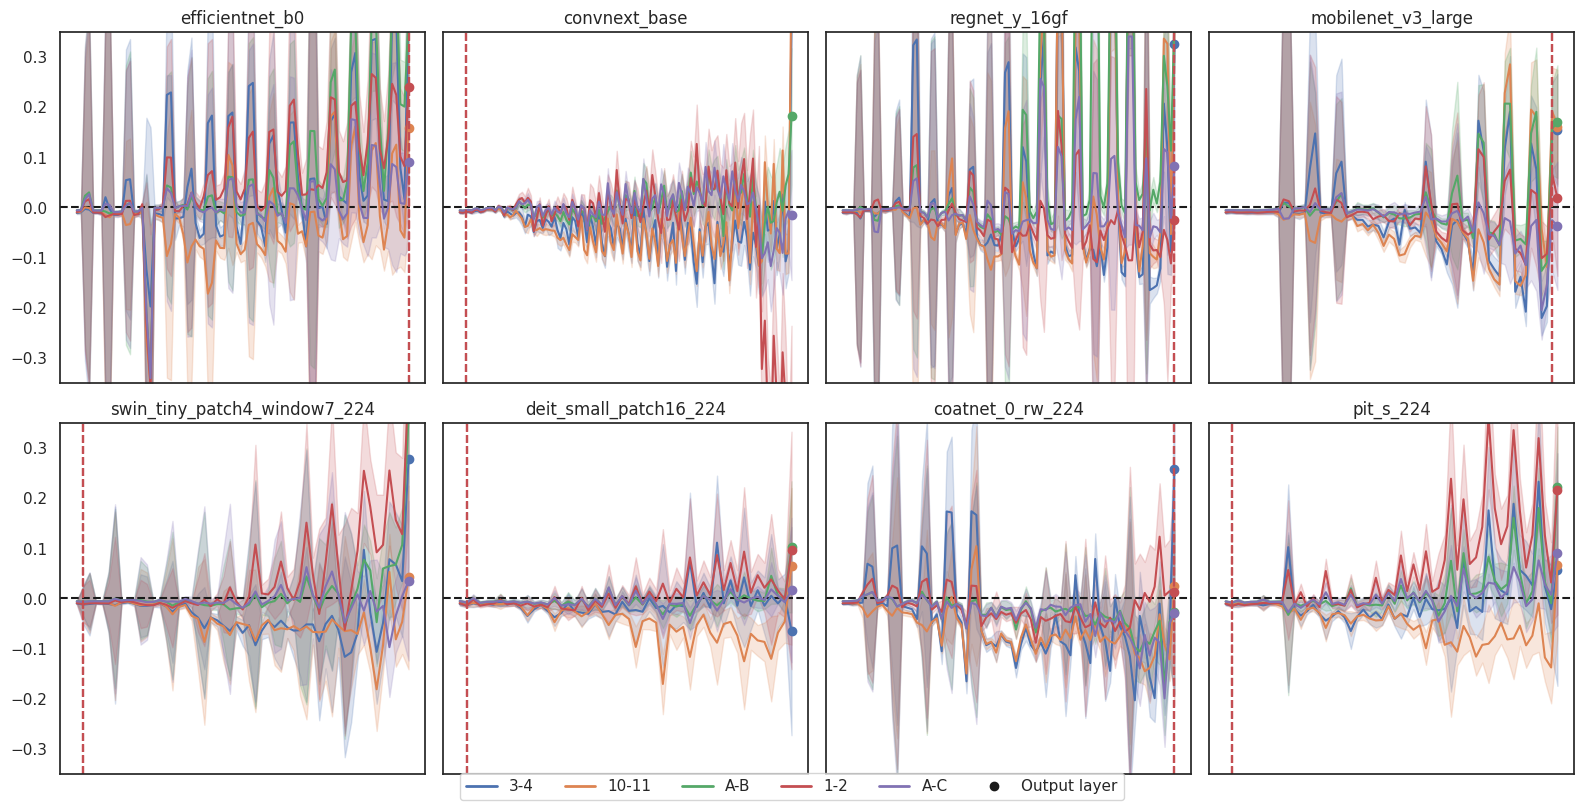

In [ ]:

# all_layers_lineplot_colab.py
# Adapted for Colab and updated path structure:
# /content/drive/MyDrive/cmpe489/results/{distance_type}/special/{network_name}/{background}_{pretraining}/{transf_code}/{type_ds}/_{distance_type}.df

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -- Imports from your repo (ensure PYTHONPATH includes /content/gestalt-DNNs) --
from src.utils.create_stimuli.drawing_utils import DrawShape
from src.utils.Config import Config
from src.utils.misc import config_to_path_special, human_CSE_exp2, additional_nets, recurrent, self_superv_net, transformers
from src.utils.misc import from_netname_to_str

# --- PARAMETERS ---
transf_code    = 't'
bk             = 'random'
network_names  = additional_nets  # list of 8 network names
normalize      = False
distance_type  = 'euclidean'      # or 'cossim'
type_ds_list   = list(human_CSE_exp2.keys())[:5]  # first 5 condition pairs

# base results directory
results_root = '/content/drive/MyDrive/cmpe489/results'

# --- Helper functions ---

def collect(config, type_ds):
    """
    Load the per-layer distance dictionary for a given config + condition.
    Path: results_root/distance_type/special/network_name/background_pretraining/transf_code/type_ds/_distance_type.df
    """
    # ensure type_ds on config for path building
    config.type_ds = type_ds
    """
    Load the per-layer distance dictionary for a given config + condition.
    Path: results_root/distance_type/special/network_name/background_pretraining/transf_code/type_ds/_distance_type.df
    """
    # build folder path
    folder = os.path.join(
        results_root,
        distance_type,
        'special',
        config.network_name,
        f"{bk}_{config.pretraining}",
        transf_code,
        type_ds
    )
    df_path = os.path.join(folder, f"_{distance_type}.df")
    with open(df_path, 'rb') as f:
        cs = pickle.load(f)
    return cs


def compute_base_comp(type_ds, network_name):
    """
    Compute mean and std of configural effect per-layer for one network & condition pair.
    type_ds format: '1-2' means compare 'array1' vs 'array2'.
    """
    # build Config
    pt = 'kitti' if network_name=='prednet' else 'ImageNet'
    cfg = Config(
        project_name='Pomerantz',
        distance_type=distance_type,
        verbose=False,
        network_name=network_name,
        pretraining=pt,
        weblogger=0,
        is_pycharm=False,
        background=bk,
        draw_obj=DrawShape(
            background='black' if bk in ('black','random') else bk,
            img_size=np.array((224,224)), width=10
        ),
        transf_code=transf_code
    )

    base_str, comp_str = type_ds.split('-')
    base_cond      = 'array' + base_str
    composite_cond = 'array' + comp_str

    base_dict      = collect(cfg, base_cond)
    comp_dict      = collect(cfg, composite_cond)

    layers = list(base_dict.keys())

    # compute raw CE arrays per layer
    CE = []
    for l in layers:
        A = np.array(base_dict[l])
        B = np.array(comp_dict[l])
        if distance_type=='cossim':
            vals = A - B
        else:
            vals = (B - A) / (B + A)
        CE.append(vals)

    # optional normalization (using Experiment1 style empty baseline)
    if normalize:
        # load empty vs empty-single baseline from special
        empty_dict = collect(cfg, 'empty')
        empty_single_dict = collect(cfg, 'empty-single')
        norm = []
        for l in layers:
            norm_vals = np.array(empty_dict[l]) - np.array(empty_single_dict[l])
            norm.append(np.mean(norm_vals))
        norm = np.array(norm)

    # compute per-layer mean/std
    CE_m   = np.array([
        np.mean(vals)/norm[i] if normalize else np.mean(vals)
        for i,vals in enumerate(CE)
    ])
    CE_std = np.array([
        0 if normalize else np.std(vals)
        for vals in CE
    ])

    # filter out any NaN layers
    valid = np.isfinite(CE_m)
    return CE_m[valid], CE_std[valid], [layers[i] for i,ok in enumerate(valid) if ok]

# --- Plotting ---
sns.set(style="white")
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.close('all')

# build subplot grid (8 networks)
fig, axes = plt.subplots(2, 4, figsize=(16,8), sharey=True)
axes = axes.flatten()

# set y-limits based on distance_type
if distance_type=='cossim':
    ymin, ymax = -0.25, 0.3
else:
    ymin, ymax = -0.35, 0.35
for ax in axes:
    ax.set_ylim(ymin, ymax)
    ax.axhline(0, color='k', linestyle='--')

# plot each network
conds = type_ds_list
for ax, nn in zip(axes, network_names):
    for idx, cond in enumerate(conds):
        CE_m, CE_s, layers = compute_base_comp(cond, nn)
        x = np.arange(len(layers))
        c = color_cycle[idx % len(color_cycle)]
        ax.plot(x, CE_m, color=c)
        ax.fill_between(x, CE_m+CE_s, CE_m-CE_s, alpha=0.2, color=c)
        # mark first linear layer
        lin_idx = next((i for i,l in enumerate(layers) if 'Linear' in l), None)
        if lin_idx is not None:
            ax.axvline(lin_idx, color='r', linestyle='--')
        ax.plot(x[-1], CE_m[-1], 'o', color=c)

    ax.set_xticks([])
    ax.set_title(from_netname_to_str(nn), fontsize=12)

# global legend
lines = [plt.Line2D([0],[0],color=color_cycle[i],lw=2) for i in range(len(conds))]
lines += [plt.Line2D([0],[0],marker='o',color='k',lw=0)]
labels = conds + ['Output layer']
fig.legend(lines, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd

df = pd.read_pickle("/content/drive/MyDrive/cmpe489/results/euclidean/special/deit_small_patch16_224/random_ImageNet/t/array3/_euclidean.df")

df.keys()

dict_keys(['0:0: Conv2d', '1:6: Linear', '2:10: Linear', '3:15: Linear', '4:19: Linear', '5:24: Linear', '6:28: Linear', '7:33: Linear', '8:37: Linear', '9:42: Linear', '10:46: Linear', '11:51: Linear', '12:55: Linear', '13:60: Linear', '14:64: Linear', '15:69: Linear', '16:73: Linear', '17:78: Linear', '18:82: Linear', '19:87: Linear', '20:91: Linear', '21:96: Linear', '22:100: Linear', '23:105: Linear', '24:109: Linear', '25:114: Linear', '26:118: Linear', '27:123: Linear', '28:127: Linear', '29:132: Linear', '30:136: Linear', '31:141: Linear', '32:145: Linear', '33:150: Linear', '34:154: Linear', '35:159: Linear', '36:163: Linear', '37:168: Linear', '38:172: Linear', '39:177: Linear', '40:181: Linear', '41:186: Linear', '42:190: Linear', '43:195: Linear', '44:199: Linear', '45:204: Linear', '46:208: Linear', '47:213: Linear', '48:217: Linear', '49:224: Linear'])

#### Boxplot familiarity

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


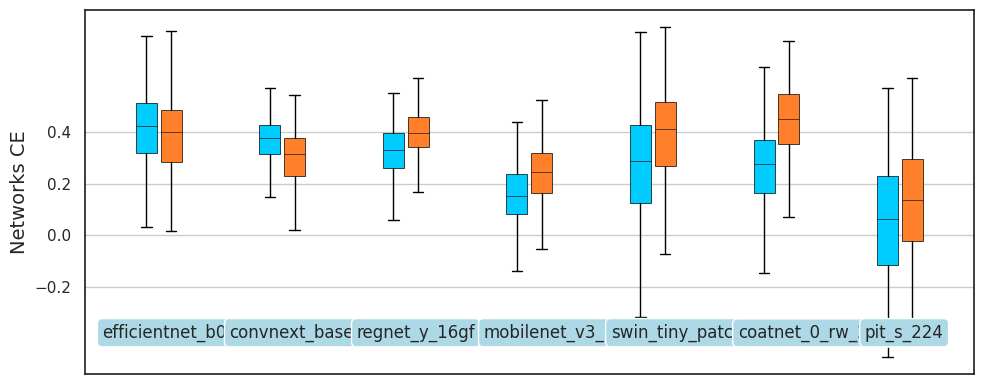

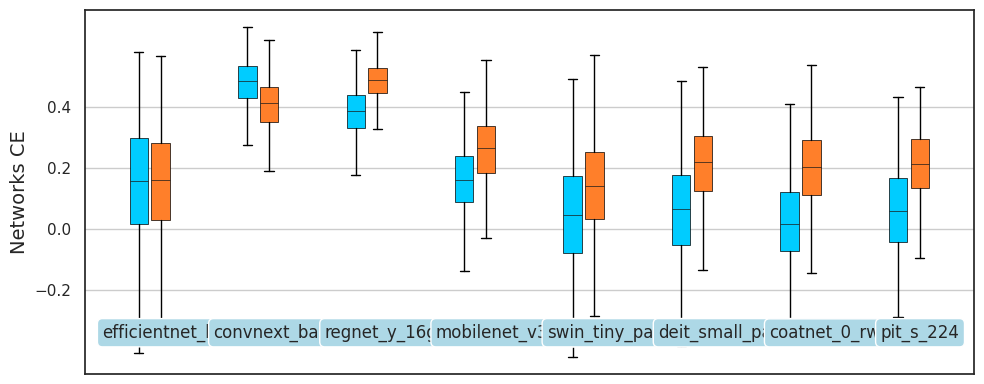

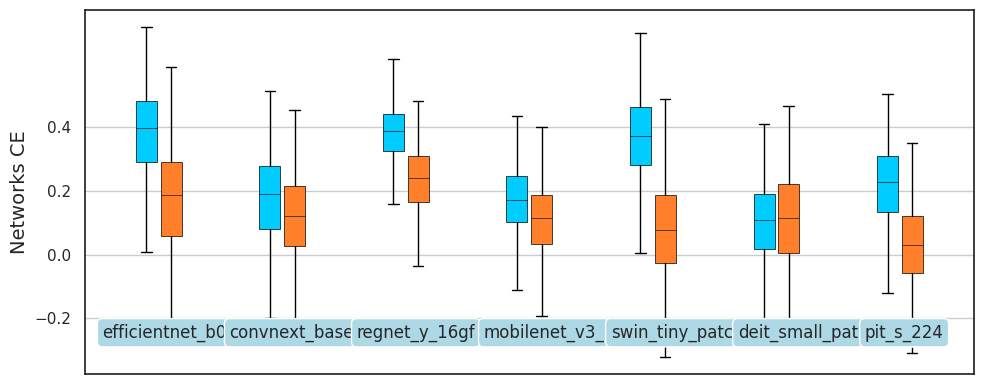

In [ ]:
# all_layers_boxplot_colab.py
# Colab-ready script for Experiment 2 barplots (sets of CSE at a fixed depth)

# 0) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 1) Imports
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure your repo is on PYTHONPATH
import sys
sys.path.append('/content/gestalt-DNNs')  # adjust path if needed

from src.utils.create_stimuli.drawing_utils import DrawShape
from src.utils.Config import Config
from src.utils.misc import config_to_path_special, brain_score_nn, recurrent, self_superv_net, transformers, from_netname_to_str
from src.utils.net_utils import get_layer_from_depth_str

sns.set(style="white")

# 2) Parameters
transf = 't'
bk = 'random'
network_names = additional_nets   # your 8 networks
distance_type = 'euclidean'  # or 'cossim'
depth_layer = 'last_l'
results_root = '/content/drive/MyDrive/cmpe489/results'

# define the cse_pairs to plot
cse_sets = [
    [['array3','array4'], ['array3','array4_curly']],
    [['array10','array11'], ['array10','array11_curly']],
    [['arrayA','arrayB'], ['arrayA','curly_composite_with_space']]
]

# 3) Helper functions

def collect(pretraining, network_name, type_ds):
    # build Config
    cfg = Config(
        project_name='Pomerantz',
        distance_type=distance_type,
        verbose=False,
        network_name=network_name,
        pretraining=pretraining,
        weblogger=0,
        is_pycharm=False,
        type_ds=type_ds,
        background=bk,
        draw_obj=DrawShape(
            background='black' if bk in ('black','random') else bk,
            img_size=np.array((224,224)), width=10
        ),
        transf_code=transf
    )
    # add type_ds for path builder
    cfg.type_ds = type_ds
    # construct path to pickle
    rel = config_to_path_special(cfg)
    folder = os.path.join(results_root, rel)
    df_path = os.path.join(folder, f"_{distance_type}.df")
    # load
    with open(df_path,'rb') as f:
        cs = pickle.load(f)
    # locate desired layer
    layers = list(cs.keys())
    ll = get_layer_from_depth_str(layers, depth_layer)
    return np.array(cs[ll])


def compute_base_comp(base, comp, net):
    pt = 'kitti' if net=='prednet' else 'ImageNet'
    base_dist = collect(pt, net, base)
    comp_dist = collect(pt, net, comp)
    if distance_type=='cossim':
        CSE = base_dist - comp_dist
    else:
        CSE = (comp_dist - base_dist)/(comp_dist + base_dist)
    return np.mean(CSE), np.std(CSE), CSE

# 4) Plotting function

def plot_sets(cse_pairs, save_name):
    color_cycle = [(0/255,204/255,255/255), (255/255,127/255,42/255)]
    fig, ax = plt.subplots(1,1,figsize=(10,4), sharey=True)
    ax.grid(axis='y')

    def plot_bar(m, s, distr, x):
        span, space = 0.4, 0.03
        width = span/len(m)
        for iidx in range(len(distr)):
            pos = x - span/2 + width*iidx
            bp = ax.boxplot(
                distr[iidx], positions=[pos], widths=width-space,
                patch_artist=True, showfliers=False,
                boxprops={'facecolor':color_cycle[iidx], 'lw':0.5},
                medianprops={'color':'k','linewidth':0.5})
            if bp['medians'][0].get_ydata()[0] < 0:
                bp['boxes'][0].set(hatch='////', facecolor='w',
                                   edgecolor=color_cycle[iidx])

    net_plotted = []
    net_CSE_m = {}  # mean
    net_CSE_s = {}  # std
    net_CSE_d = {}  # distribution

    # compute for each network
    for net in network_names:
        mean_dict, std_dict, dist_dict = {}, {}, {}
        for base, comp in cse_pairs:
            label = f"{base}-{comp}"
            m,s,d = compute_base_comp(base, comp, net)
            mean_dict[label], std_dict[label], dist_dict[label] = m,s,d
        # include only if positive median
        if np.median(list(dist_dict.values())[0]) > 0:
            net_plotted.append(net)
            net_CSE_m[net] = mean_dict
            net_CSE_s[net] = std_dict
            net_CSE_d[net] = dist_dict

    # plot
    for idx, net in enumerate(net_plotted):
        labels = list(net_CSE_m[net].keys())
        m = list(net_CSE_m[net].values())
        s = list(net_CSE_s[net].values())
        d = list(net_CSE_d[net].values())
        plot_bar(m, s, d, idx)
        ax.annotate(
            from_netname_to_str(net),
            xy=(idx/len(net_plotted)+0.02,0.1),
            xycoords='axes fraction', fontsize=12,
            bbox=dict(boxstyle='round', fc='lightblue'))

    ax.set_xticks(range(len(net_plotted)))
    ax.set_xticklabels(['']*len(net_plotted))
    ax.set_yticks([-0.2,0,0.2,0.4])
    ax.set_ylabel('Networks CE', fontsize=14)
    plt.tight_layout()
    # save

    plt.show()

# 5) Run for each cse set
for pairs, name in zip(cse_sets, ['set3-4','set10-11','setA-Bcurly']):
    plot_sets(pairs, f'barplot_{name}')

#### Boxplot

In [ ]:
# 0) Mount Google Drive (only once per session)
from google.colab import drive
drive.mount('/content/drive')

# 1) Imports and paths
import os, sys, pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp

# Make your repo importable
sys.path.append('/content/gestalt-DNNs')  # adjust if needed

from src.utils.create_stimuli.drawing_utils import DrawShape
from src.utils.Config import Config
from src.utils.misc import (
    config_to_path_special,
    brain_score_nn,
    human_CSE_exp2,
    from_netname_to_str
)
from src.utils.net_utils import get_layer_from_depth_str

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


new pairs: ['3-4', '10-11', 'A-B', '1-2', 'A-C']


<ipython-input-185-0d2e2e8c1cb4>:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


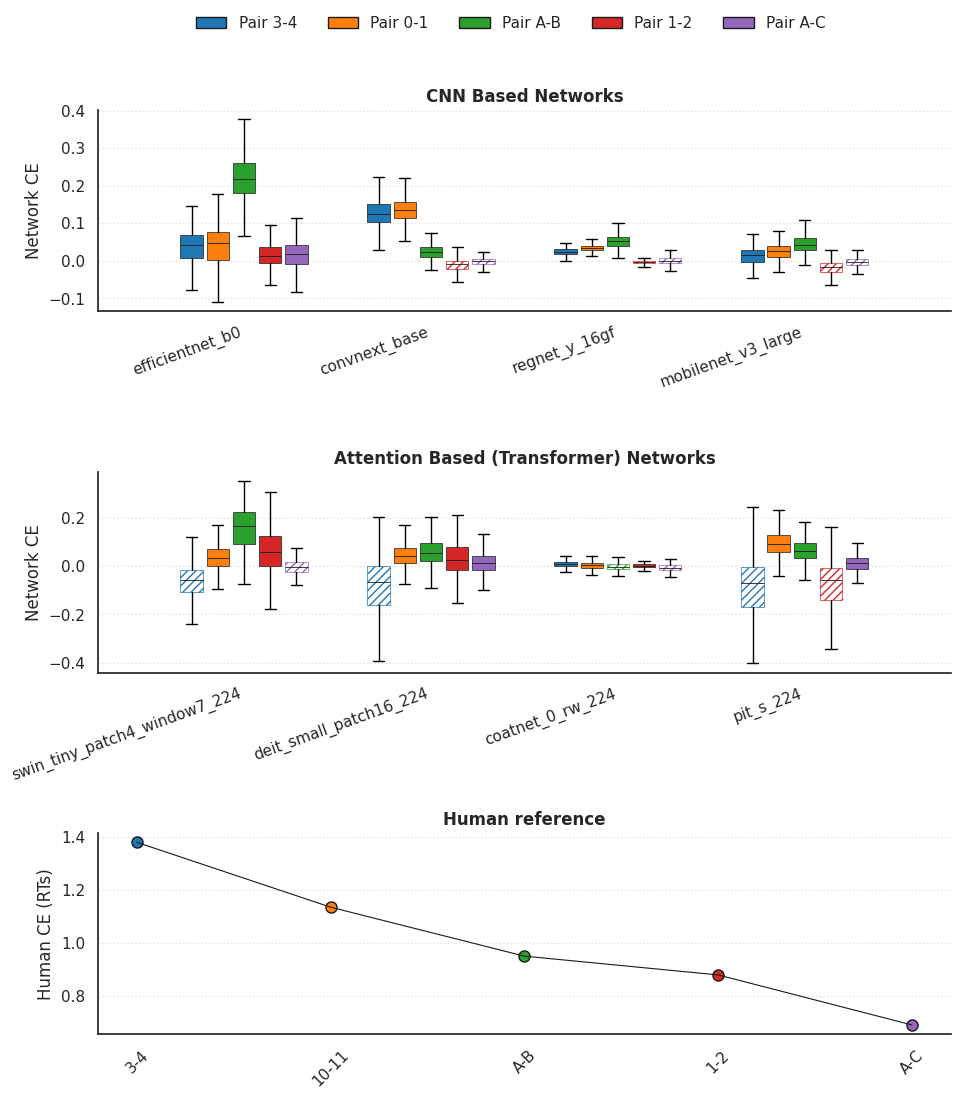

new pairs: ['6-8', '3-5', 'A-D', '6-9', 'A-F']


<ipython-input-185-0d2e2e8c1cb4>:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


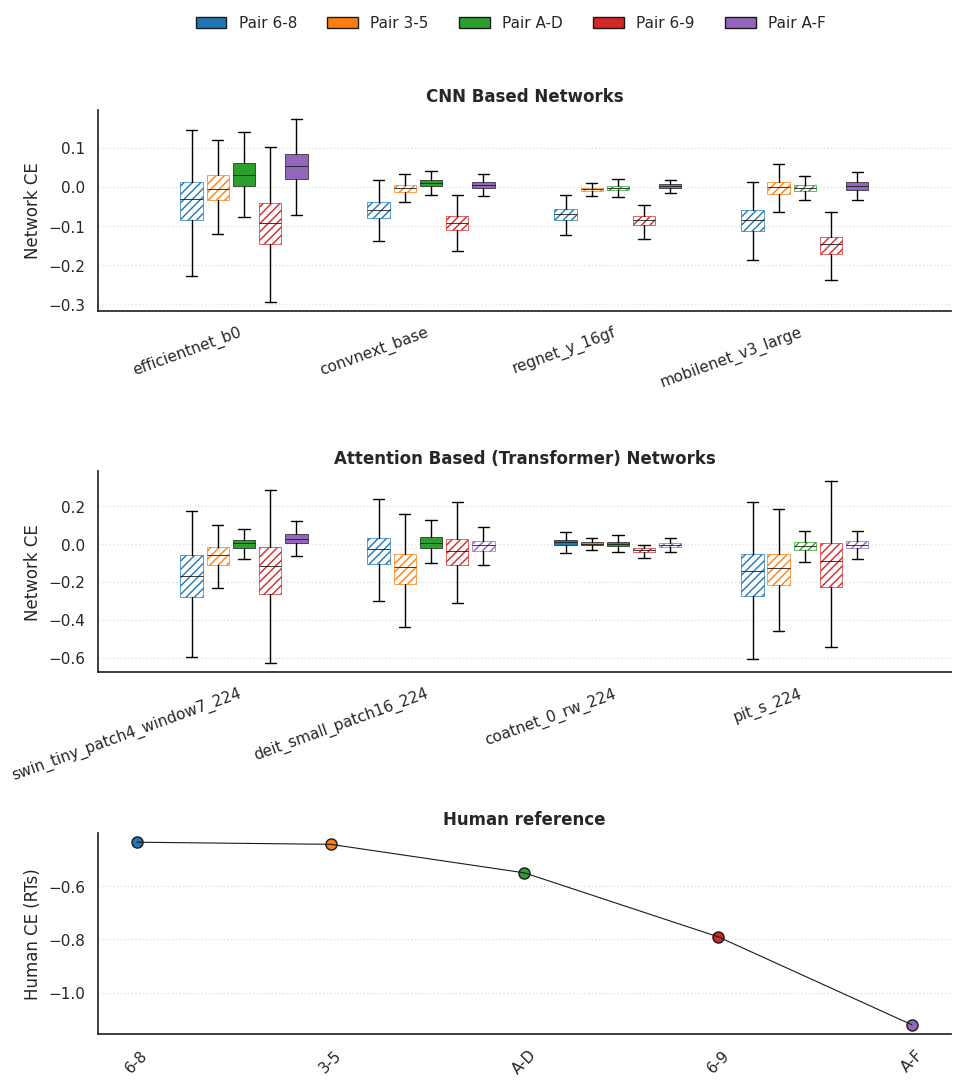

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'axes.spines.right': False,
                     'axes.spines.top':   False})

def set_boxplot_vertical(pairs, save_name, split=4):
    """
    Three stacked rows:
        • Row-1 : first `split` networks
        • Row-2 : remaining networks
        • Row-3 : human RT reference
    Each network appears once on the x-axis; each CSE pair is a
    differently coloured box within that network’s slot.
    """
    n_pairs    = len(pairs)           # 5
    n_networks = len(network_names)   # 8
    nets_A     = network_names[:split]
    nets_B     = network_names[split:]

    # -------- 1)  pre-compute all distance vectors -----------------------
    stats = {}                 # {net : [dist_vec_pair0, …, dist_vec_pair4]}
    for net in network_names:
        dists = []
        for base, comp in pairs:
            _, _, _, dvec = compute_base_comp(base, comp, net)
            dists.append(dvec)
        stats[net] = dists

    # -------- 2)  basic figure layout ------------------------------------
    fig, axes = plt.subplots(3, 1, figsize=(11, 12),
                             gridspec_kw={'hspace': 0.8},
                             sharey=False)

    axA, axB, axC = axes

    # -------- 3)  colour palette for pairs -------------------------------
    colour_cycle = plt.cm.tab10.colors   # 10 distinct colours
    pair_cols    = colour_cycle[:n_pairs]

    # -------- 4)  helper to draw one row of networks ---------------------
    def plot_row(ax, nets, pair_cols):
        width    = 0.12                       # width of each box
        gap      = 0.02                       # tiny gap between adjacent boxes
        offsets  = [(j - (n_pairs-1)/2)*(width+gap) for j in range(n_pairs)]
        x_ticks  = np.arange(len(nets))

        for i, net in enumerate(nets):
            for j, dvec in enumerate(stats[net]):
                pos = x_ticks[i] + offsets[j]
                bp  = ax.boxplot(
                        dvec, positions=[pos], widths=width,
                        patch_artist=True, showfliers=False,
                        boxprops={'facecolor': pair_cols[j],
                                  'edgecolor': 'k',
                                  'linewidth': 0.5},
                        medianprops={'color': 'k', 'linewidth': 0.6})
                # hatch if median < 0
                median_val = np.median(dvec)
                if median_val < 0:
                    bp['boxes'][0].set(hatch='////',
                                       facecolor='white',
                                       edgecolor=pair_cols[j])

        ax.set_xticks(x_ticks)
        ax.set_xticklabels([from_netname_to_str(n) for n in nets],
                           rotation=20, ha='right')
        ax.set_ylabel('Network CE')
        ax.grid(axis='y', linestyle=':', alpha=.6)


    # -------- 5)  draw the two network rows ------------------------------
    plot_row(axA, nets_A, pair_cols)
    axA.set_title('CNN Based Networks', fontweight='bold')

    plot_row(axB, nets_B, pair_cols)
    axB.set_title('Attention Based (Transformer) Networks', fontweight='bold')

    # -------- 6)  human reference row ------------------------------------
    human_vals = [human_CSE_exp2[k] for k in pairs_to_keys(pairs)]
    for i, (val, col) in enumerate(zip(human_vals, pair_cols)):
        axC.plot(i, val, marker='o', ms=8,
                markerfacecolor=col, markeredgecolor='k', linestyle='None')
    axC.plot(range(n_pairs), human_vals, lw=.8, color='k')        # baseline

    axC.set_xticks(range(n_pairs))
    axC.set_xticklabels([f"{b.replace('array','')}-{c.replace('array','')}"
                         for b, c in pairs],
                        rotation=45)
    axC.set_ylabel('Human CE (RTs)')
    axC.set_title('Human reference', fontweight="bold")
    axC.grid(axis='y', linestyle=':', alpha=.6)

    # -------- 7)  legend (pair colours) ----------------------------------
    legend_elems = [Patch(facecolor=pair_cols[i], edgecolor='k',
                          label=f'Pair {pairs[i][0][-1]}-{pairs[i][1][-1]}')
                    for i in range(n_pairs)]
    fig.legend(handles=legend_elems,
               bbox_to_anchor=(0.5, 0.97), loc='upper center',
               ncol=n_pairs, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'/content/{save_name}.png', dpi=300)
    plt.show()


set_boxplot_vertical(cse_first5, 'boxplot_first5_cossim_vertical')
set_boxplot_vertical(cse_last5,  'boxplot_last5_cossim_vertical')